In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive

 breast_cancer_checkpoints  'Geetha Raj Chinnamsetty Resume (4) (1) (2).pdf'
'Colab Notebooks'	     IDC_regular_ps50_idx5.zip


In [5]:
!cp /content/drive/MyDrive/IDC_regular_ps50_idx5.zip /content/

In [6]:
!ls

drive  IDC_regular_ps50_idx5.zip  sample_data


In [7]:
DATASET_PATH = "/content/IDC_regular_ps50_idx5"

In [10]:
import os

!unzip -qq /content/IDC_regular_ps50_idx5.zip -d /content/

sample_patient = os.listdir(DATASET_PATH)[0]
print(sample_patient)
print(os.listdir(os.path.join(DATASET_PATH, sample_patient)))

12870
['0', '1']


In [11]:
patient_ids = [
    p for p in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, p))
]

print("Total patients:", len(patient_ids))


Total patients: 279


In [12]:
train_patients, temp_patients = train_test_split(
    patient_ids, test_size=0.3, random_state=42
)

val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.5, random_state=42
)

print("Train patients:", len(train_patients))
print("Val patients:", len(val_patients))
print("Test patients:", len(test_patients))


Train patients: 195
Val patients: 42
Test patients: 42


In [13]:
def collect_image_paths(patient_list):
    paths = []
    labels = []

    for patient in patient_list:
        patient_path = os.path.join(DATASET_PATH, patient)

        for label in ["0", "1"]:
            class_path = os.path.join(patient_path, label)
            if os.path.exists(class_path):
                for img in os.listdir(class_path):
                    if img.endswith(".png"):
                        paths.append(os.path.join(class_path, img))
                        labels.append(int(label))

    return paths, labels

In [14]:
train_paths, train_labels = collect_image_paths(train_patients)
val_paths, val_labels = collect_image_paths(val_patients)
test_paths, test_labels = collect_image_paths(test_patients)

print("Train images:", len(train_paths))
print("Val images:", len(val_paths))
print("Test images:", len(test_paths))


Train images: 196801
Val images: 40061
Test images: 40662


In [15]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=train_labels
)

class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}

class_weight_dict

{0: np.float64(0.7047030092957303), 1: np.float64(1.7212815085626323)}

In [16]:
IMG_SIZE = (224, 224)

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

In [17]:
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    return img, label

In [18]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [19]:
base_model = tf.keras.applications.DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [20]:
#classifier head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(base_model.input, output)

In [21]:
#correct metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="acc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc")
    ]
)

In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight_dict
)



Epoch 1/10
6151/6151 ━━━━━━━━━━━━━━━━━━━━ 683s 105ms/step - acc: 0.7727 - auc: 0.8640 - loss: 0.4681 - precision: 0.5626 - recall: 0.8231 - val_acc: 0.7960 - val_auc: 0.8923 - val_loss: 0.4402 - val_precision: 0.5751 - val_recall: 0.8672
Epoch 2/10
6151/6151 ━━━━━━━━━━━━━━━━━━━━ 617s 100ms/step - acc: 0.8202 - auc: 0.8913 - loss: 0.4083 - precision: 0.6289 - recall: 0.8172 - val_acc: 0.7933 - val_auc: 0.8972 - val_loss: 0.4341 - val_precision: 0.5705 - val_recall: 0.8762
Epoch 3/10
6151/6151 ━━━━━━━━━━━━━━━━━━━━ 623s 101ms/step - acc: 0.8260 - auc: 0.8962 - loss: 0.3987 - precision: 0.6380 - recall: 0.8264 - val_acc: 0.7925 - val_auc: 0.9021 - val_loss: 0.4337 - val_precision: 0.5684 - val_recall: 0.8858
Epoch 4/10
6151/6151 ━━━━━━━━━━━━━━━━━━━━ 667s 108ms/step - acc: 0.8282 - auc: 0.8976 - loss: 0.3969 - precision: 0.6415 - recall: 0.8273 - val_acc: 0.7974 - val_auc: 0.9070 - val_loss: 0.4266 - val_precision: 0.5744 - val_recall: 0.8948
Epoch 5/10
6151/6151 ━━━━━━━━━━━━━━━━━━━━ 613s 1

In [23]:
y_true = []
y_probs = []

for imgs, labels in test_ds:
    probs = model.predict(imgs)
    y_probs.extend(probs.flatten())
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_probs = np.array(y_probs)

y_pred = (y_probs >= 0.5).astype(int)


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [24]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[23431  6178]
 [ 1185  9868]]
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     29609
           1       0.61      0.89      0.73     11053

    accuracy                           0.82     40662
   macro avg       0.78      0.84      0.80     40662
weighted avg       0.86      0.82      0.83     40662



In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,827,525 (29.86 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 7,038,016 (26.85 MB)

 Optimizer params: 526,340 (2.01 MB)

In [26]:
last_conv_layer_name = "conv5_block16_concat"

In [27]:
#creation of GRAD-CAM model
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[
        model.get_layer(last_conv_layer_name).output,
        model.output
    ]
)

In [28]:
import tensorflow as tf
import numpy as np

def make_gradcam_heatmap(img_array, grad_model):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_score = predictions[:, 0]  # malignant score

    # Compute gradients
    grads = tape.gradient(class_score, conv_outputs)

    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight feature maps
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [29]:
for images, labels in test_ds.take(1):
    sample_image = images[0]
    sample_label = labels[0]

In [33]:
img_array = tf.expand_dims(sample_image, axis=0)

In [34]:
heatmap = make_gradcam_heatmap(img_array, grad_model)

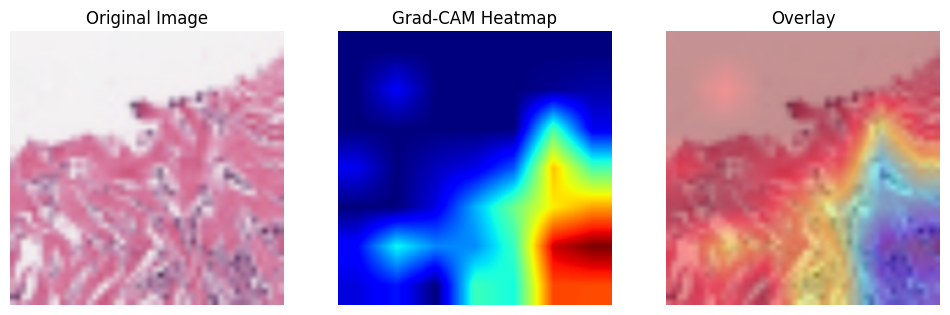

In [36]:
import matplotlib.pyplot as plt
import cv2

# Resize heatmap to image size
heatmap_resized = cv2.resize(heatmap, (224, 224))

# Convert to color
heatmap_colored = cv2.applyColorMap(
    np.uint8(255 * heatmap_resized),
    cv2.COLORMAP_JET
)

# Original image
original_img = (sample_image.numpy() * 255).astype("uint8")

# Overlay
superimposed_img = cv2.addWeighted(
    original_img, 0.6,
    heatmap_colored, 0.4,
    0
)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(original_img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap_resized, cmap="jet")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(superimposed_img)
plt.axis("off")

plt.savefig("gradcam_example.png", bbox_inches="tight")
plt.show()

In [37]:
from google.colab import files
files.download("gradcam_example.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>